In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.info()
y_train = train['type'] #label
X_train = train.drop(labels=['type','id'], axis=1) #
test = test.drop(labels=['id'], axis=1)
#Change Color to Integer Value
X_train2 = train['color']
test2 = test['color']
le = LabelEncoder()
X_train2 = le.fit_transform(X_train2)
test2 = le.fit_transform(test2)
X_train['color'] = X_train2
test['color'] = test2


le2 = LabelEncoder()
y_train2 = le2.fit_transform(y_train)
y = pd.DataFrame({'type' :y_train2})
y_train = y.values.ravel()

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
 #                                                  test_size = 0.25, random_state=0)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


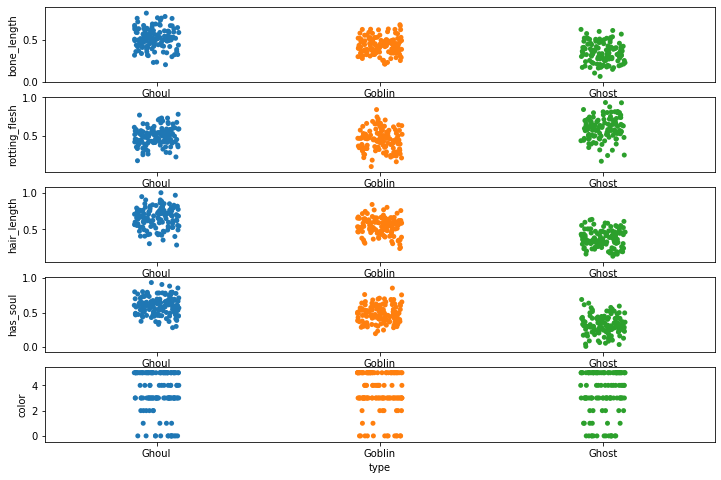

In [17]:
import matplotlib.pyplot as plt
plt.rc('axes', unicode_minus = False)
import seaborn as sns
fig, ax = plt.subplots(5, figsize=(12,8))
Labels = X_train.columns
for i, lab in enumerate(Labels):
    sns.stripplot(train['type'], X_train[lab], jitter = True, ax=ax[i])
    

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

LR = LogisticRegression(solver='liblinear',#,'lbfgs'
                        max_iter=10000,
                       penalty='l2',
                       C=10,
                       random_state=3,
                       multi_class='auto')
DT = DecisionTreeClassifier(max_depth=3,
                           criterion='entropy',
                           random_state=3)
KN = KNeighborsClassifier(n_neighbors=4,
                         p=2,
                         metric='minkowski')
SV = SVC(gamma='auto',
        probability=True)

Hardvoting = VotingClassifier(estimators=[('LogisticRegression', LR),
                                           ('DecisionTree', DT),
                                          ('KNeighbors', KN),
                                         ('SVM', SV)],
                                voting='hard')

Softvoting = VotingClassifier(estimators=[('LogisticRegression', LR),
                                           ('DecisionTree', DT),
                                          ('KNeighbors', KN),
                                         ('SVM', SV)],
                                voting='soft')

RF = RandomForestClassifier(n_estimators=100)
#Bagging Clssifier - Redundancy available
#Pasting - No Redundancy


Bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100,
                           max_samples = 300, bootstrap = True, #True->Bagging
                           n_jobs = -1 # -1 means use all cpu cores available
                           )
Paste_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100,
                           max_samples = 300, bootstrap = False, #True->Bagging
                           n_jobs = -1 # -1 means use all cpu cores available
                           )

AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=100,
                              algorithm="SAMME.R", learning_rate=0.5)
GradientBoost = GradientBoostingClassifier(max_depth=3, n_estimators=100,
                                          learning_rate=0.5)
print('----Validation score----')
for clf_name, clf in zip(['LogisticRegression', 'DecisionTree', 'KNeighbors', 'SVM', 'HardVoting', 'Softvoting','RandomForest', 'Bagging', 'Pasting', 'AdaBoost', 'GradientBoost'],[LR, DT, KN, SV, Hardvoting, Softvoting, RF, Bag_clf, Paste_clf, AdaBoost, GradientBoost]):
    scores = cross_val_score(estimator= clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='accuracy')
    print("ACCURACY : %f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), clf_name))

----Validation score----
ACCURACY : 0.740766 (+/- 0.05) [LogisticRegression]
ACCURACY : 0.626998 (+/- 0.09) [DecisionTree]
ACCURACY : 0.667637 (+/- 0.09) [KNeighbors]
ACCURACY : 0.662027 (+/- 0.07) [SVM]
ACCURACY : 0.705378 (+/- 0.06) [HardVoting]
ACCURACY : 0.697103 (+/- 0.08) [Softvoting]
ACCURACY : 0.719484 (+/- 0.06) [RandomForest]
ACCURACY : 0.702796 (+/- 0.07) [Bagging]
ACCURACY : 0.690699 (+/- 0.06) [Pasting]
ACCURACY : 0.643134 (+/- 0.10) [AdaBoost]
ACCURACY : 0.694625 (+/- 0.07) [GradientBoost]


In [37]:
from sklearn import metrics
acc = metrics.make_scorer(metrics.accuracy_score)
LR.get_params()

{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 3,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [40]:
params = {'C' : [1,2,5,10,25], 'max_iter' : [100, 500, 1000, 10000],
         'penalty' : ['l1', 'l2']}
clf = GridSearchCV(LR, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.7439353099730458
BestParam:{'C': 10, 'max_iter': 100, 'penalty': 'l1'}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
#LR, DT, KN, SV, Hardvoting, Softvoting, RF, Bag_clf, Paste_clf, AdaBoost, GradientBoost
DT.get_params()

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 3,
 'splitter': 'best'}

In [42]:
params = {'max_depth' : [1,3,5,10,20],
         'criterion' : ['entropy', 'gini']}
clf = GridSearchCV(DT, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.6981132075471698
BestParam:{'criterion': 'entropy', 'max_depth': 5}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
#LR, DT, KN, SV, Hardvoting, Softvoting, RF, Bag_clf, Paste_clf, AdaBoost, GradientBoost
KN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 4,
 'p': 2,
 'weights': 'uniform'}

In [44]:
params = {'n_neighbors' : [2,4,8,16,24],
         'leaf_size' : [10,20,30,50],
         'weights' : ['uniform', 'distance']}
clf = GridSearchCV(KN, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.6711590296495957
BestParam:{'leaf_size': 10, 'n_neighbors': 16, 'weights': 'distance'}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [45]:
#LR, DT, KN, SV, Hardvoting, Softvoting, RF, Bag_clf, Paste_clf, AdaBoost, GradientBoost
SV.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [46]:
params = {'C' : [0.1, 1, 2, 5, 10, 100],
         'kernel' : ['linear', 'rbf'],
         'degree' : [2,5,10,20]}
clf = GridSearchCV(SV, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.7493261455525606
BestParam:{'C': 1, 'degree': 2, 'kernel': 'linear'}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
#LR, DT, KN, SV, Hardvoting, Softvoting, RF, Bag_clf, Paste_clf, AdaBoost, GradientBoost
RF.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [50]:
params = {'n_estimators' : [5, 10, 20 ,50, 100],
         'criterion' : ['entropy', 'gini'],
         'max_depth' : [None, 3, 5, 10, 25, 50]}

clf = GridSearchCV(RF, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.7250673854447439
BestParam:{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [51]:
Bag_clf.get_params()

{'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'bootstrap': True,
 'bootstrap_features': 

In [52]:
params={'n_estimators' : [5, 10, 25, 50, 100],
       'max_samples' : [1, 2, 5, 10]}
clf = GridSearchCV(Bag_clf, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.7142857142857143
BestParam:{'max_samples': 10, 'n_estimators': 100}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [53]:
Paste_clf.get_params()

{'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'bootstrap': False,
 'bootstrap_features':

In [54]:
params={'n_estimators' : [5, 10, 25, 50, 100],
       'max_samples' : [1, 2, 5, 10, 25]}
clf = GridSearchCV(Paste_clf, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

BestScore:0.7223719676549866
BestParam:{'max_samples': 25, 'n_estimators': 100}


c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [58]:
AdaBoost.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 3,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': False,
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'learning_rate': 0.5,
 

In [ ]:
params={'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
       'n_estimators' : [100, 200, 500],
       'max_depth' : [2,3,5,10]}
clf = GridSearchCV(AdaBoost, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

In [56]:
GradientBoost.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.5,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [59]:
params={'learning_rate' : [0.001, 0.01, 0.1, 0.5, 1],
       'n_estimators' : [100, 200, 500],
       'max_depth' : [2,3,5,10]}
clf = GridSearchCV(GradientBoost, param_grid = params, scoring = acc, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
print('BestScore:{}'.format(clf.best_score_))
print('BestParam:{}'.format(clf.best_params_))

c:\users\82107\anaconda3\envs\wj\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


BestScore:0.7304582210242587
BestParam:{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 200}
